# 6. RFM-сегментация пользователей

Цель - качественно оценить аудиторию. Для каждого RFM-сегмента построить границы метрик (recency, frequency и monetary) для интерпретации этих кластеров. 

**Метрики:**
* R - (Recency) время от последней покупки пользователя до текущей даты.
* F - (Frequency) суммарное количество покупок у пользователя за всё время.
* M - (Monetary) сумма покупок за всё время.

Покупка: всё также order_approved_at — время подтверждения оплаты заказа.

In [68]:
# import required libraries

import pandas as pd
import datetime as dt
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

pd.options.mode.copy_on_write = True

Нам понадобятся все 3 датасета. Откроем их и переведём даты в формат datetime. (анализ данных см. в 1й тетради с кодом)

In [69]:
orders = pd.read_csv('olist_orders_dataset.csv')
orders.head(3)

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   

  order_estimated_delivery_date  
0           2017-10-18 00:00:00  
1           2018-08-13 00:00:00  
2           2018-09-04 00:00:00

In [70]:
# переведём все даты в datetime

orders[['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
        'order_delivered_customer_date', 'order_estimated_delivery_date']] = orders[[
        'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
        'order_delivered_customer_date', 'order_estimated_delivery_date']]\
.apply(pd.to_datetime)
orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [71]:
customers = pd.read_csv('olist_customers_dataset.csv')
customers.head(3)

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP

In [72]:
items = pd.read_csv('olist_order_items_dataset.csv')
items.head(3)

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   

   shipping_limit_date  price  freight_value  
0  2017-09-19 09:45:35   58.9          13.29  
1  2017-05-03 11:05:13  239.9          19.93  
2  2018-01-18 14:48:30  199.0          17.87

In [73]:
# Переведём shipping_limit_date в datetime

items.shipping_limit_date = pd.to_datetime(items.shipping_limit_date)
items.dtypes

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

In [74]:
# период и текущую дату определю по датам создания заказов, т.к. это экстремальные даты. 

print('Purchases from {} to {}'.format(orders['order_purchase_timestamp'].min(),
                                    orders['order_purchase_timestamp'].max()))

Purchases from 2016-09-04 21:15:19 to 2018-10-17 17:30:18


Период - чуть больше 2 лет и 1 мес.

In [75]:
period = round((orders['order_purchase_timestamp'].max() - orders['order_purchase_timestamp'].min()) / np.timedelta64(1, 'D'), 0)
period

773.0

In [77]:
# Возьмём нужные колонки из всех датасетов и создадим нужный датафрейм. 
# Т.к. у нас есть в оплаченных отменённые заказы, уберём их, потому что они не принесли деньги.

base = customers[['customer_unique_id', 'customer_id']]\
.merge(orders.query('order_status != "canceled"')[['customer_id', 'order_approved_at', 'order_id']], on='customer_id')\
.merge(items[['order_id', 'product_id', 'price']], how='left', on='order_id')
base

customer_unique_id                       customer_id  \
0       861eff4711a542e4b93843c6dd7febb0  06b8999e2fba1a1fbc88172c00ba8bc7   
1       290c77bc529b7ac935b93aa66c333dc3  18955e83d337fd6b2def6b18a428ac77   
2       060e732b5b29e8181a18229c7b0b2b5e  4e7b3e00288586ebd08712fdd0374a03   
3       259dac757896d24d7702b9acbbff3f3c  b2b6027bc5c5109e529d4dc6358b12c3   
4       345ecd01c38d18a9036ed96c73b8d066  4f2d8ab171c80ec8364f7c12e35b23ad   
...                                  ...                               ...   
112714  1a29b476fee25c95fbafc67c5ac95cf8  17ddf5dd5d51696bb3d7c6291687be6f   
112715  d52a67c98be1cf6a5c84435bd38d095d  e7b71a9017aa05c9a7fd292d714858e8   
112716  e9f50caf99f032f0bf3c55141f019d99  5e28dfe12db7fb50a4b2f691faecea5e   
112717  73c2643a0a458b49f58cea58833b192e  56b18e2166679b8a959d72dd06da27f9   
112718  84732c5050c01db9b23e19ba39899398  274fa6071e5e17fe303b9748641082c8   

         order_approved_at                          order_id  \
0      2017-05-16 15:22:12  00e7ee1b050b8499577073aeb2a297a1   
1      2018-01-12 20:58:32  29150127e6685892b6eab3eec79f59c7   
2      2018-05-20 16:19:10  b2059ed67ce144a36e2aa97d2c9e9ad2   
3      2018-03-13 17:29:19  951670f92359f4fe4a63112aa7306eba   
4      2018-07-29 10:10:09  6b7d50bd145f6fc7f33cebabd7e49d0f   
...                    ...                               ...   
112714 2018-04-07 16:08:45  6760e20addcf0121e9d58f2f1ff14298   
112715 2018-04-04 08:35:12  9ec0c8947d973db4f4e8dcf1fbfa8f1b   
112716 2018-04-08 20:30:03  fed4434add09a6f332ea398efd656a5c   
112717 2017-11-03 21:31:20  e31ec91cea1ecf97797787471f98a8c2   
112718 2017-12-19 18:50:39  28db69209a75e59f20ccbb5c36a20b90   

                              product_id   price  
0       a9516a079e37a9c9c36b9b78b10169e8  124.99  
1       4aa6014eceb682077f9dc4bffebc05b0  289.00  
2       bd07b66896d6f1494f5b86251848ced7  139.94  
3       a5647c44af977b148e0a3a4751a09e2e  149.94  
4       9391a573abe00141c56e38d84d7d5b3b  230.00  
...                                  ...     ...  
112714  ccb4503d9d43d245d3b295d0544f988b   74.90  
112715  9ede6b0570a75a4b9de4f383329f99ee  114.90  
112716  7a5d2e1e131a860ae7d18f6fffa9d689   37.00  
112717  f819f0c84a64f02d3a5606ca95edd272  689.00  
112718  017692475c1c954ff597feda05131d73   13.99  

[112719 rows x 6 columns]

In [78]:
base.isna().sum()

customer_unique_id      0
customer_id             0
order_approved_at      20
order_id                0
product_id            611
price                 611
dtype: int64

In [79]:
# удалим пустые ячейки - это неоплаченные заказы и те недоступные, которых даже нет в датасете items 
base = base.dropna()
base.isna().sum()

customer_unique_id    0
customer_id           0
order_approved_at     0
order_id              0
product_id            0
price                 0
dtype: int64

In [80]:
# " I am doing in real time by setting the NOW date at one day after the last purchase. 
# This date will be used as a reference to calculate the Recency score." 

NOW = pd.to_datetime(orders.order_purchase_timestamp.max() + dt.timedelta(days=1)) 
NOW

Timestamp('2018-10-18 17:30:18')

In [81]:
# найдём разницу между датами покупок и текущей датой

base['dif_days'] = round((NOW - base.order_approved_at) / np.timedelta64(1, 'D'), 0)
base

customer_unique_id                       customer_id  \
0       861eff4711a542e4b93843c6dd7febb0  06b8999e2fba1a1fbc88172c00ba8bc7   
1       290c77bc529b7ac935b93aa66c333dc3  18955e83d337fd6b2def6b18a428ac77   
2       060e732b5b29e8181a18229c7b0b2b5e  4e7b3e00288586ebd08712fdd0374a03   
3       259dac757896d24d7702b9acbbff3f3c  b2b6027bc5c5109e529d4dc6358b12c3   
4       345ecd01c38d18a9036ed96c73b8d066  4f2d8ab171c80ec8364f7c12e35b23ad   
...                                  ...                               ...   
112714  1a29b476fee25c95fbafc67c5ac95cf8  17ddf5dd5d51696bb3d7c6291687be6f   
112715  d52a67c98be1cf6a5c84435bd38d095d  e7b71a9017aa05c9a7fd292d714858e8   
112716  e9f50caf99f032f0bf3c55141f019d99  5e28dfe12db7fb50a4b2f691faecea5e   
112717  73c2643a0a458b49f58cea58833b192e  56b18e2166679b8a959d72dd06da27f9   
112718  84732c5050c01db9b23e19ba39899398  274fa6071e5e17fe303b9748641082c8   

         order_approved_at                          order_id  \
0      2017-05-16 15:22:12  00e7ee1b050b8499577073aeb2a297a1   
1      2018-01-12 20:58:32  29150127e6685892b6eab3eec79f59c7   
2      2018-05-20 16:19:10  b2059ed67ce144a36e2aa97d2c9e9ad2   
3      2018-03-13 17:29:19  951670f92359f4fe4a63112aa7306eba   
4      2018-07-29 10:10:09  6b7d50bd145f6fc7f33cebabd7e49d0f   
...                    ...                               ...   
112714 2018-04-07 16:08:45  6760e20addcf0121e9d58f2f1ff14298   
112715 2018-04-04 08:35:12  9ec0c8947d973db4f4e8dcf1fbfa8f1b   
112716 2018-04-08 20:30:03  fed4434add09a6f332ea398efd656a5c   
112717 2017-11-03 21:31:20  e31ec91cea1ecf97797787471f98a8c2   
112718 2017-12-19 18:50:39  28db69209a75e59f20ccbb5c36a20b90   

                              product_id   price  dif_days  
0       a9516a079e37a9c9c36b9b78b10169e8  124.99     520.0  
1       4aa6014eceb682077f9dc4bffebc05b0  289.00     279.0  
2       bd07b66896d6f1494f5b86251848ced7  139.94     151.0  
3       a5647c44af977b148e0a3a4751a09e2e  149.94     219.0  
4       9391a573abe00141c56e38d84d7d5b3b  230.00      81.0  
...                                  ...     ...       ...  
112714  ccb4503d9d43d245d3b295d0544f988b   74.90     194.0  
112715  9ede6b0570a75a4b9de4f383329f99ee  114.90     197.0  
112716  7a5d2e1e131a860ae7d18f6fffa9d689   37.00     193.0  
112717  f819f0c84a64f02d3a5606ca95edd272  689.00     349.0  
112718  017692475c1c954ff597feda05131d73   13.99     303.0  

[112093 rows x 7 columns]

Вычислим интересующие нас метрики

In [100]:
# Recency - Время от последней покупки пользователя до текущей даты - это минимальное значение нашей разницы дат
# Frequency - суммарное количество покупок у пользователя за всё время
# Monetary - сумма покупок за всё время.

rfm = base.groupby('customer_unique_id').agg({'dif_days': 'min', 'order_id': 'count', 'price': 'sum'}).reset_index()
rfm.rename(columns={'dif_days': 'recency', 'order_id': 'frequency', 'price': 'monetary'}, inplace=True)
rfm.sort_values('monetary', ascending=False).head(3)

customer_unique_id  recency  frequency  monetary
3788   0a0a92112bd4c708ca5fde585afaa872    381.0          8   13440.0
81004  da122df9eeddfedc1dc1f5349a1a690c    563.0          2    7388.0
43937  763c8b1c9c68a0229c42c9fc6f662b93     94.0          4    7160.0

In [101]:
rfm.describe()

recency     frequency      monetary
count  94976.000000  94976.000000  94976.000000
mean     288.003990      1.180224    142.085769
std      152.996039      0.620609    216.107543
min       45.000000      1.000000      0.850000
25%      164.000000      1.000000     47.900000
50%      269.000000      1.000000     89.890000
75%      397.000000      1.000000    155.000000
max      763.000000     24.000000  13440.000000

Помним из предыдущего анализа (Project_e-commerce_by_Natalie_Lebedeva(Swan).ipynb), что 93049 пользователей совершили покупку только один раз. Поэтому статданные не являются сюрпризом.

В течение последних 44 дней не было покупок вообще. Так и есть: последний оплаченный заказ был в 2018-09-03 17:40:06. И это странно. Возможно, прежде чем выводить rfm, стоило изучить и отладить данный факт. Но мне не кажется правильным подгонать датасет, убирая из него месяцы, если я не уверена, что причина в технической неполадке.

In [84]:
# # chart setting

# sns.set(
#     font_scale=1,
#     rc={'figure.figsize':(30,5)}
#         )

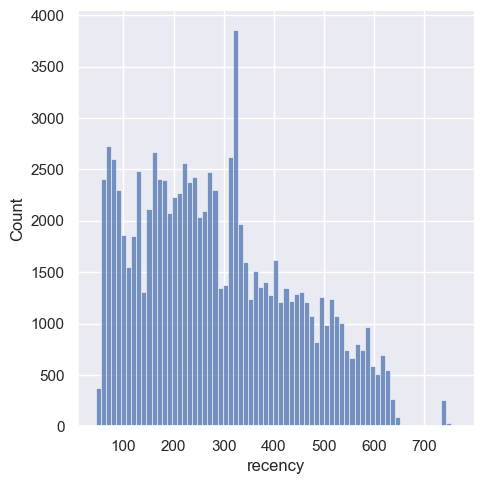

In [102]:
sns.set(rc = {'figure.figsize' : (16, 4)})
sns.displot(rfm.recency)
plt.savefig("recency_bars", dpi=100, bbox_inches="tight")
plt.show()

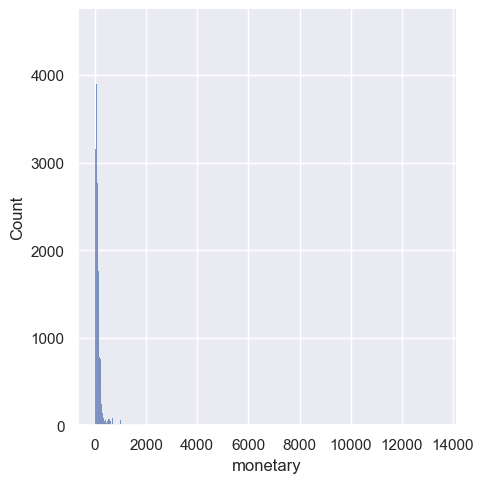

In [86]:
sns.displot(rfm.monetary)
plt.savefig("monetary_bars", dpi=100, bbox_inches="tight")
plt.show()

### Создаём кластеры

In [87]:
rfm.frequency.sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 18,
       20, 21, 24], dtype=int64)

Предлагаю для кластеризации recency и monetary использовать квартили. А для frequency, т.к. 75% клиентов сделали по 1 покупке, разбить следующим образом:

1. 1
2. 2-10
3. 9-20
4. 20

In [88]:
quintiles = rfm[['recency', 'monetary']].quantile([.25, .5, .75]).to_dict()
quintiles

{'recency': {0.25: 164.0, 0.5: 269.0, 0.75: 397.0},
 'monetary': {0.25: 47.9, 0.5: 89.89, 0.75: 155.0}}

In [104]:
# задаём функции для сегментов

def r_score(x):
    if x <= quintiles['recency'][.25]:
        return 4
    elif x <= quintiles['recency'][.5]:
        return 3
    elif x <= quintiles['recency'][.75]:
        return 2
    else:
        return 1

def m_score(x):
    if x <= quintiles['monetary'][.25]:
        return 1
    elif x <= quintiles['monetary'][.5]:
        return 2
    elif x <= quintiles['monetary'][.75]:
        return 3
    else:
        return 4 
    
def f_score(x):
    if x == 1:
        return 1
    elif x <= 10:
        return 2
    elif x <= 20:
        return 3
    else:
        return 4  


In [105]:
# добавляем сегменты в таблицу

rfm['R'] = rfm['recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['frequency'].apply(lambda x: f_score(x))
rfm['M'] = rfm['monetary'].apply(lambda x: m_score(x))
rfm

customer_unique_id  recency  frequency  monetary  R  F  M
0      0000366f3b9a7992bf8c76cfdf3221e2    161.0          1    129.90  4  1  3
1      0000b849f77a49e4a4ce2b2a4ca5be3f    164.0          1     18.90  4  1  1
2      0000f46a3911fa3c0805444483337064    587.0          1     69.00  1  1  2
3      0000f6ccb0745a6a4b88665a16c9f078    371.0          1     25.99  2  1  1
4      0004aac84e0df4da2b147fca70cf8255    338.0          1    180.00  2  1  4
...                                 ...      ...        ...       ... .. .. ..
94971  fffcf5a5ff07b0908bd4e2dbc735a684    497.0          2   1570.00  1  2  4
94972  fffea47cd6d3cc0a88bd621562a9d061    312.0          1     64.89  2  1  2
94973  ffff371b4d645b6ecea244b27531430a    618.0          1     89.90  1  1  3
94974  ffff5962728ec6157033ef9805bacc48    169.0          1    115.00  3  1  3
94975  ffffd2657e2aad2907e67c3e9daecbeb    533.0          1     56.99  1  1  2

[94976 rows x 7 columns]

In [106]:
# Соединяем все 3 оценки в 1 колонку
rfm['rfm_score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head(3)

customer_unique_id  recency  frequency  monetary  R  F  M  \
0  0000366f3b9a7992bf8c76cfdf3221e2    161.0          1     129.9  4  1  3   
1  0000b849f77a49e4a4ce2b2a4ca5be3f    164.0          1      18.9  4  1  1   
2  0000f46a3911fa3c0805444483337064    587.0          1      69.0  1  1  2   

  rfm_score  
0       413  
1       411  
2       112

In [92]:
rfm.describe()

recency     frequency      monetary             R             F  \
count  94976.000000  94976.000000  94976.000000  94976.000000  94976.000000   
mean     288.003990      1.180224    142.085769      2.507212      1.124642   
std      152.996039      0.620609    216.107543      1.119955      0.331492   
min       45.000000      1.000000      0.850000      1.000000      1.000000   
25%      164.000000      1.000000     47.900000      2.000000      1.000000   
50%      269.000000      1.000000     89.890000      3.000000      1.000000   
75%      397.000000      1.000000    155.000000      4.000000      1.000000   
max      763.000000     24.000000  13440.000000      4.000000      4.000000   

                  M  
count  94976.000000  
mean       2.498042  
std        1.118782  
min        1.000000  
25%        1.000000  
50%        2.000000  
75%        3.000000  
max        4.000000

### Описание сегментов 

* champions: покупали недавно, покупают много, (он у нас 1 такой)))
* potential loyalists: покупали недавно, больше 1 раза,
* new customers: покупали недавно, 1 раз,
* loyal customers: покупают чаще других, но последняя покупка была не так близко,
* need attention: покупали больше 1 раза, но последняя покупка была не так близко,
* at risk: мы их теряем, купили достаточно давно, но больше 1 раза,
* hibernating: уснувшие, возможно, потерянные, купили всего 1 раз и очень давно

Добавим это описание в таблицу

In [109]:
segt_map = {
    r'11': 'hibernating',
    r'[1-2][1-4]': 'at risk',
    r'[2-3]1': 'need attention',
    r'3[2-4]': 'loyal customers',
    r'41': 'new customers',
    r'4[2-3]': 'potential loyalists',
    r'44': 'champions'
}

In [136]:
rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
rfm.sort_values('rfm_score', ascending=False)


customer_unique_id  recency  frequency  monetary  R  F  \
0      c8460e4251689ba205045f3ea17884a1     70.0         24   4080.00  4  4   
5      ca77025e7201e3b30c44b472ff346268    139.0         12    806.61  4  3   
8      63cfc61cee11cbe306bff5857d00bfe4    143.0         11    579.81  4  3   
7      d3383e8df3cd44cd351aecff92e34627    158.0         12    213.84  4  3   
6      8d50f5eadf50201ccdcedfb9e2ac8455     59.0         16    729.62  4  3   
...                                 ...      ...        ...       ... .. ..   
91105  182d47b668f339c6047445253ffdf0fa    594.0          1     42.00  1  1   
91104  182e134f5a24ee479aa38749a5748cb0    410.0          1     25.99  1  1   
91103  b92a6f95096e923d4eaf9192e17d5095    458.0          1     19.99  1  1   
91102  b92ca24fab9d1a01b2a4eb08c858d04e    452.0          1     19.90  1  1   
94975  47351f35d6ead07e0f2d39a2adaf73be    400.0          1     33.49  1  1   

       M rfm_score              Segment  
0      4       444            champions  
5      4       434  potential loyalists  
8      4       434  potential loyalists  
7      4       434  potential loyalists  
6      4       434  potential loyalists  
...   ..       ...                  ...  
91105  1       111          hibernating  
91104  1       111          hibernating  
91103  1       111          hibernating  
91102  1       111          hibernating  
94975  1       111          hibernating  

[94976 rows x 9 columns]

In [137]:
rfm_share = rfm.groupby('Segment', as_index=False).agg(total =('customer_unique_id', 'count'))
rfm_share['share'] = round((rfm_share.total/rfm.customer_unique_id.nunique()*100), 2)
rfm_share =  rfm_share.sort_values(['total'], ascending=False).reset_index(drop=True) 
rfm_share

Segment  total  share
0              at risk  26210  27.60
1        new customers  20957  22.07
2          hibernating  20897  22.00
3       need attention  20847  21.95
4  potential loyalists   3041   3.20
5      loyal customers   3023   3.18
6            champions      1   0.00

In [138]:
segments = rfm_share.Segment.tolist()
segments

['at risk',
 'new customers',
 'hibernating',
 'need attention',
 'potential loyalists',
 'loyal customers',
 'champions']

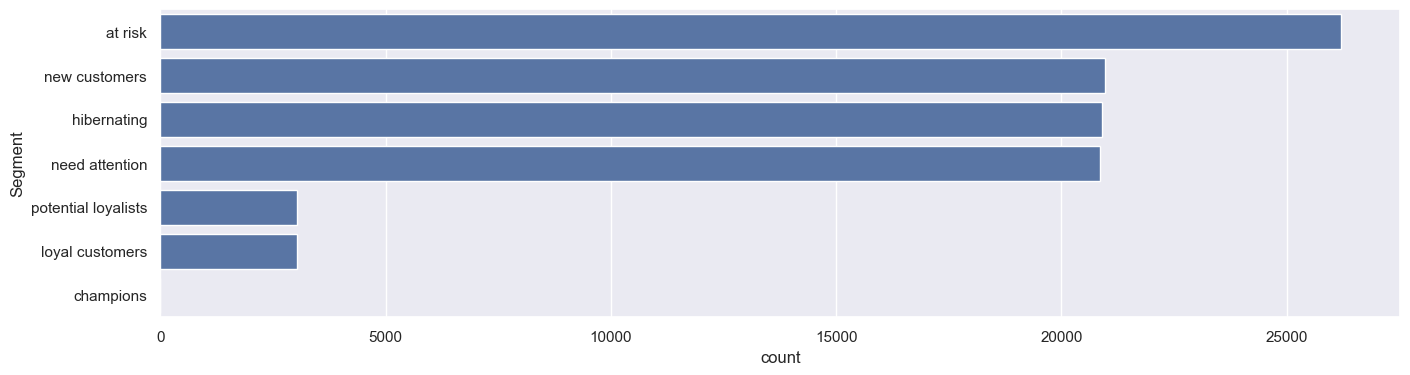

In [139]:
ax = sns.countplot(rfm.Segment, order=segments)
plt.savefig("segments_bars", dpi=100, bbox_inches="tight")
plt.show()

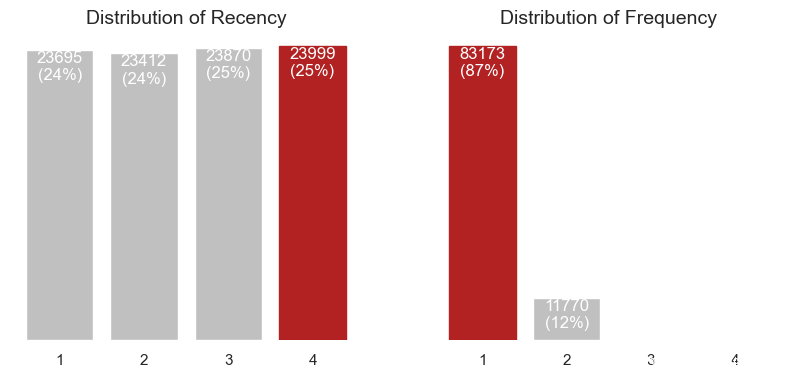

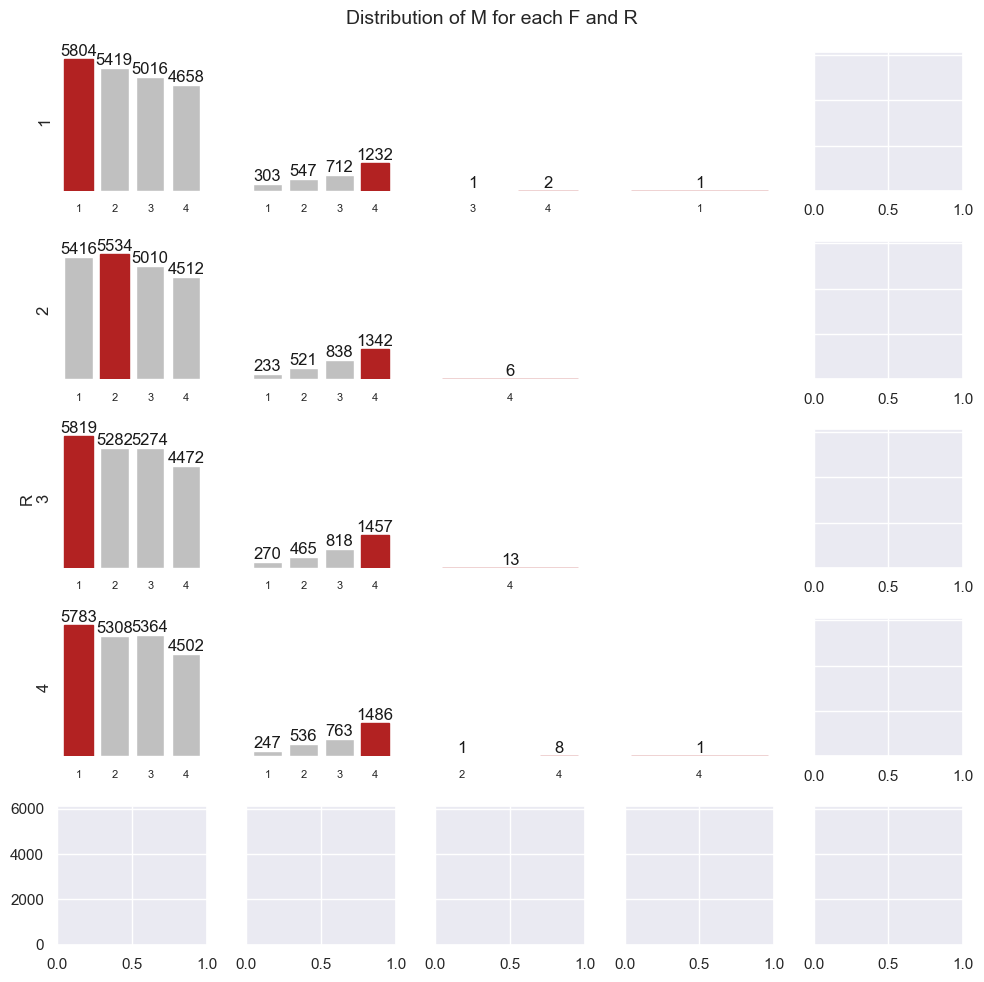

In [97]:
# строим визуализации

#plot the distribution of customers over R and F
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(['R', 'F']):
    parameters = {'R':'Recency', 'F':'Frequency'}
    y = rfm[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')
plt.savefig("distribution_R_F.png", dpi=100, bbox_inches="tight")
plt.show()

# plot the distribution of M for RF score
fig, axes = plt.subplots(nrows=5, ncols=5,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 5)
f_range = range(1, 5)
for r in r_range:
    for f in f_range:
        y = rfm[(rfm['R'] == r) & (rfm['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 5:
            if f == 3:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution of M for each F and R',
             fontsize=14)
plt.tight_layout()
plt.savefig("distribution_M_for_RF.png", dpi=100, bbox_inches="tight")
plt.show()

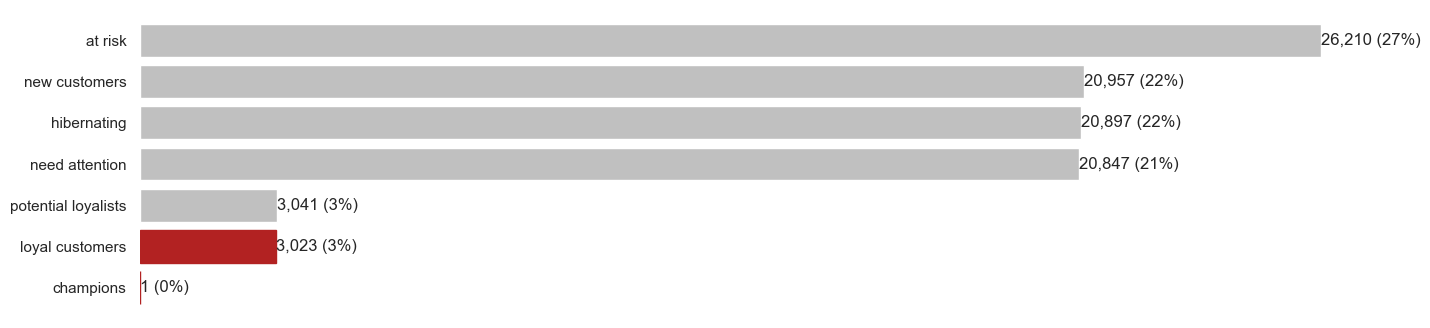

In [98]:
# count the number of customers in each segment
segments_counts = rfm['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['champions', 'loyal customers']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )
plt.savefig("segments_counts.png", dpi=100, bbox_inches="tight")
plt.show()

# Выводы

* Достаточно равномерное распределение параметра Recency
* 87% клиентов купили 1 раз и 12% - 2 раза.
* У нас есть 1 чемпион с параметрами 444
* 22% клиентов купили 1 раз и больше года назад
* 27,5% покупали последний раз достаточно давно (около года назад и больше), но больше 1 раза
* 22% купили 1 раз где-то полгода - 9 месяцев назад.
* Лояльных клиентов и потенциально лояльных очень мало (по 3%)